In [2]:
import os

# Define the path to the parent directory containing the *_sync folders
parent_dir = "/globalwork/datasets/KITTI-360/data_3d_raw"

# List all directories in the parent directory
scene_dirs = [d for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d)) and d.endswith("_sync")]

# Iterate over each scene directory
for scene_dir in scene_dirs:
    # Define the path to the velodyne_points folder
    velodyne_path = os.path.join(parent_dir, scene_dir, "velodyne_points", "data")

    if os.path.exists(velodyne_path) and os.path.isdir(velodyne_path):
        # Count the number of files in the velodyne_points folder
        num_scans = len([f for f in os.listdir(velodyne_path) if os.path.isfile(os.path.join(velodyne_path, f))])

        # Print the result
        print(f"{scene_dir}: {num_scans} Velodyne scans")
    else:
        print(f"{scene_dir}: velodyne_points folder not found")

2013_05_28_drive_0000_sync: 11518 Velodyne scans
2013_05_28_drive_0002_sync: 19240 Velodyne scans
2013_05_28_drive_0003_sync: 1031 Velodyne scans
2013_05_28_drive_0004_sync: 11587 Velodyne scans
2013_05_28_drive_0005_sync: 6743 Velodyne scans
2013_05_28_drive_0006_sync: 9699 Velodyne scans
2013_05_28_drive_0007_sync: 3396 Velodyne scans
2013_05_28_drive_0009_sync: 14056 Velodyne scans
2013_05_28_drive_0010_sync: 3836 Velodyne scans


In [1]:
import numpy as np
import os
import open3d as o3d

# Define PLY types
ply_dtypes = dict([(b"int8", "i1"), (b"char", "i1"), (b"uint8", "u1"), (b"uchar", "u1"), (b"int16", "i2"), (b"short", "i2"), (b"uint16", "u2"), (b"ushort", "u2"), (b"int32", "i4"), (b"int", "i4"), (b"uint32", "u4"), (b"uint", "u4"), (b"float32", "f4"), (b"float", "f4"), (b"float64", "f8"), (b"double", "f8")])


valid_formats = {"ascii": "", "binary_big_endian": ">", "binary_little_endian": "<"}


def read_ply(filename, triangular_mesh=False):
    """
    Read ".ply" files
    Parameters
    ----------
    filename : string
        the name of the file to read.
    Returns
    -------
    result : array
        data stored in the file
    Examples
    --------
    Store data in file
    >>> points = np.random.rand(5, 3)
    >>> values = np.random.randint(2, size=10)
    >>> write_ply('example.ply', [points, values], ['x', 'y', 'z', 'values'])
    Read the file
    >>> data = read_ply('example.ply')
    >>> values = data['values']
    array([0, 0, 1, 1, 0])

    >>> points = np.vstack((data['x'], data['y'], data['z'])).T
    array([[ 0.466  0.595  0.324]
           [ 0.538  0.407  0.654]
           [ 0.850  0.018  0.988]
           [ 0.395  0.394  0.363]
           [ 0.873  0.996  0.092]])
    """

    with open(filename, "rb") as plyfile:

        # Check if the file start with ply
        if b"ply" not in plyfile.readline():
            raise ValueError("The file does not start whith the word ply")

        # get binary_little/big or ascii
        fmt = plyfile.readline().split()[1].decode()
        if fmt == "ascii":
            raise ValueError("The file is not binary")

        # get extension for building the numpy dtypes
        ext = valid_formats[fmt]

        # PointCloud reader vs mesh reader
        if triangular_mesh:

            # Parse header
            num_points, num_faces, properties = parse_mesh_header(plyfile, ext)

            # Get point data
            vertex_data = np.fromfile(plyfile, dtype=properties, count=num_points)

            # Get face data
            face_properties = [("k", ext + "u1"), ("v1", ext + "i4"), ("v2", ext + "i4"), ("v3", ext + "i4")]
            faces_data = np.fromfile(plyfile, dtype=face_properties, count=num_faces)

            # Return vertex data and concatenated faces
            faces = np.vstack((faces_data["v1"], faces_data["v2"], faces_data["v3"])).T
            data = [vertex_data, faces]

        else:

            # Parse header
            num_points, properties = parse_header(plyfile, ext)

            # Get data
            data = np.fromfile(plyfile, dtype=properties, count=num_points)

    return data


def parse_header(plyfile, ext):
    # Variables
    line = []
    properties = []
    num_points = None

    while b"end_header" not in line and line != b"":
        line = plyfile.readline()

        if b"element" in line:
            line = line.split()
            num_points = int(line[2])

        elif b"property" in line:
            line = line.split()
            properties.append((line[2].decode(), ext + ply_dtypes[line[1]]))

    return num_points, properties


def parse_mesh_header(plyfile, ext):
    # Variables
    line = []
    vertex_properties = []
    num_points = None
    num_faces = None
    current_element = None

    while b"end_header" not in line and line != b"":
        line = plyfile.readline()

        # Find point element
        if b"element vertex" in line:
            current_element = "vertex"
            line = line.split()
            num_points = int(line[2])

        elif b"element face" in line:
            current_element = "face"
            line = line.split()
            num_faces = int(line[2])

        elif b"property" in line:
            if current_element == "vertex":
                line = line.split()
                vertex_properties.append((line[2].decode(), ext + ply_dtypes[line[1]]))
            elif current_element == "vertex":
                if not line.startswith("property list uchar int"):
                    raise ValueError("Unsupported faces property : " + line)

    return num_points, num_faces, vertex_properties

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [15]:
def load_velodyne_points(file_path):
    points = np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)
    return points


def load_labels(ply_file_path):
    # ply_data = o3d.io.read_point_cloud(ply_file_path)
    # labels = np.asarray(ply_data.colors)  # Assuming the labels are stored as colors

    ply_data = read_ply(ply_file_path)
    labels = np.asarray(ply_data)
    return labels


def load_poses(pose_file_path):
    with open(pose_file_path, "r") as f:
        lines = f.readlines()

    poses = {}
    for line in lines:
        values = line.strip().split()
        frame_index = int(values[0])
        pose_matrix = np.array(values[1:], dtype=np.float32).reshape(3, 4)
        pose_matrix = np.vstack((pose_matrix, [0, 0, 0, 1]))  # Convert to 4x4 matrix
        poses[frame_index] = pose_matrix

    return poses


def parse_poses(pose_file_path, calibration):
    poses = []

    Tr = calibration["Tr"]
    Tr_inv = np.linalg.inv(Tr)

    with open(pose_file_path) as file:
        for line in file:
            values = [float(v) for v in line.strip().split()]
            frame_index = int(values[0])
            values = values[1:]

            pose = np.zeros((4, 4))
            pose[0, 0:4] = values[0:4]
            pose[1, 0:4] = values[4:8]
            pose[2, 0:4] = values[8:12]
            pose[3, 3] = 1.0

            poses[frame_index] = np.matmul(Tr_inv, np.matmul(pose, Tr))

    return poses


def parse_calibration(filename):
    calib = {}

    with open(filename) as calib_file:
        for line in calib_file:
            key, content = line.strip().split(":")
            values = [float(v) for v in content.strip().split()]

            pose = np.zeros((4, 4))
            pose[0, 0:4] = values[0:4]
            pose[1, 0:4] = values[4:8]
            pose[2, 0:4] = values[8:12]
            pose[3, 3] = 1.0

            calib[key] = pose
    return calib

In [16]:
scene_10_points = "/globalwork/datasets/KITTI-360/data_3d_raw/2013_05_28_drive_0010_sync/velodyne_points/data"
scene_10_labels = "/globalwork/datasets/KITTI-360/data_3d_semantics/2013_05_28_drive_0010_sync/dynamic"
scene_10_points_dir = "/globalwork/datasets/KITTI-360/data_3d_raw/2013_05_28_drive_0010_sync/velodyne_points/data"
scene_10_labels_dir = "/globalwork/datasets/KITTI-360/data_3d_semantics/2013_05_28_drive_0010_sync/static"
point_files = sorted([f for f in os.listdir(scene_10_points_dir) if f.endswith(".bin")])
label_files = sorted([f for f in os.listdir(scene_10_labels_dir) if f.endswith(".ply")])
pose_file_path = "/globalwork/datasets/KITTI-360/data_poses/2013_05_28_drive_0010_sync/poses.txt"
# calibration_file_path = "/globalwork/datasets/KITTI-360/data_poses/2013_05_28_drive_0010_sync/calib.txt"
# calibration = parse_calibration(calibration_file_path)
poses = load_poses(pose_file_path)

In [5]:
# Example of mapping labels to points
# Assuming each PLY file covers a range of frames, you need to map each point cloud frame to the corresponding label file
for point_file in point_files:
    frame_index = int(point_file.split(".")[0])  # Extract frame index from filename

    # Find corresponding label file (based on frame ranges)
    for label_file in label_files:
        start_frame, end_frame = map(int, label_file.split(".")[0].split("_"))
        if start_frame <= frame_index <= end_frame:
            labels = load_labels(os.path.join(scene_10_labels_dir, label_file))
            points = load_velodyne_points(os.path.join(scene_10_points_dir, point_file))

            # Do something with points and labels
            break

In [21]:
# Specify the frame range
start_frame = 2
end_frame = 208

point_files = sorted([f for f in os.listdir(scene_10_points_dir) if f.endswith(".bin")])
all_points = []
last_pose = poses[1]

for point_file in point_files:
    frame_index = int(point_file.split(".")[0])  # Extract frame index from filename
    if start_frame <= frame_index <= end_frame:
        point_file_path = os.path.join(scene_10_points_dir, point_file)
        if os.path.exists(point_file_path):
            points = load_velodyne_points(point_file_path)
            if frame_index in poses:
                pose = poses[frame_index]
                last_pose = pose  # Update the last available pose
            else:
                # print(f"No pose available for frame {frame_index}, using the last available pose")
                if last_pose is not None:
                    pose = last_pose
            pose = pose.T
            points[:, 0:3] = points[:, 0:3] @ pose[:3, :3] + pose[3, :3]
            all_points.append(points)
        else:
            print(f"File {point_file_path} does not exist")
            raise FileNotFoundError(f"File {point_file_path} does not exist")

# Concatenate all the points into a single array
all_points_concatenated = np.vstack(all_points)

In [23]:
print(all_points_concatenated.shape)
print(labels.shape)

(24218527, 4)
(2119978,)


In [26]:
labels

array([(-1367.4249, 2089.5022, 115.5365, 131, 131, 117, 17, 17542, 1),
       (-1365.3448, 2091.1355, 115.5589, 250, 221, 177, 11, 11150, 1),
       (-1365.3761, 2091.2146, 115.5579, 118,  92,  65, 11, 11150, 1),
       ...,
       (-1399.87  , 2074.15  , 113.808 ,  42,  40,  42,  7,  7000, 0),
       (-1399.91  , 2074.07  , 113.88  ,  63,  76,  64,  7,  7000, 0),
       (-1399.94  , 2074.08  , 113.879 ,  49,  56,  53,  7,  7000, 0)],
      dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('red', 'u1'), ('green', 'u1'), ('blue', 'u1'), ('semantic', '<i4'), ('instance', '<i4'), ('visible', 'u1')])

In [29]:
# Set print options to avoid scientific notation
np.set_printoptions(precision=4, suppress=True)
all_points_concatenated[:, 3]

array([0.1211, 0.168 , 0.1211, ..., 0.    , 0.    , 0.    ], dtype=float32)

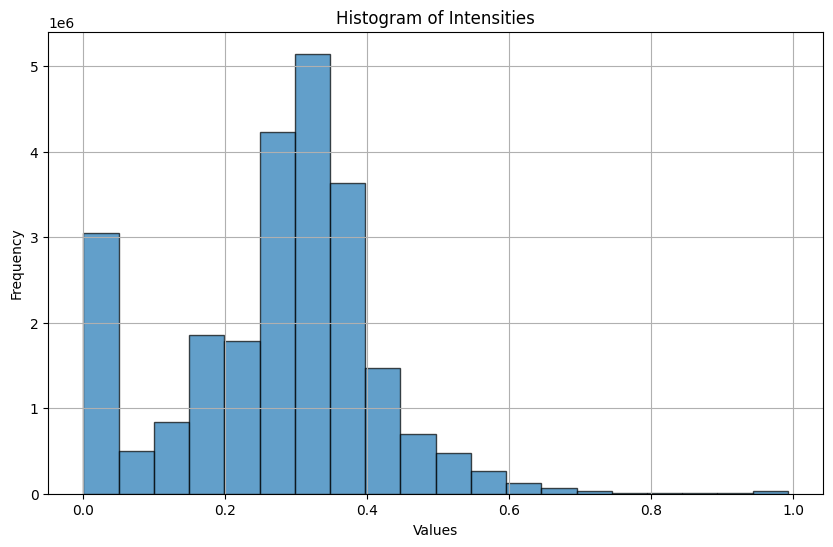

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace this with your actual data)
data = all_points_concatenated[:, 3]

# Define bin edges
num_bins = 20
bins = np.linspace(data.min(), data.max(), num_bins + 1)

# Compute the histogram
hist, bin_edges = np.histogram(data, bins=bins)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(data, bins=bins, edgecolor="black", alpha=0.7)
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.title("Histogram of Intensities")
plt.grid(True)
plt.show()